In [1]:
import argparse
from collections import namedtuple
from dataclasses import dataclass
import json
import logging
import os
import random
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import transformers
import wandb
from tqdm.auto import tqdm, trange


logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s: %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

In [2]:
def get_data(file_path, sample, num_choices):
    data_file = open(file_path, "r")
    logger.info("Reading QA instances from jsonl dataset at: %s", file_path)
    item_jsons = []
    item_ids = []
    questions = []
    choice_lists = []
    answer_ids = []
    for line in data_file:
        item_jsons.append(json.loads(line.strip()))

    if sample != -1:
        item_jsons = random.sample(item_jsons, sample)
        logger.info("Sampling %d examples", sample)

    for item_json in tqdm(item_jsons,total=len(item_jsons)):
        item_id = item_json["id"]

        question_text = item_json["question"]["stem"]

        choice_label_to_id = {}
        choice_text_list = []
        choice_context_list = []
        choice_label_list = []
        choice_annotations_list = []

        any_correct = False
        choice_id_correction = 0

        for choice_id, choice_item in enumerate(item_json["question"]["choices"]):
            choice_label = choice_item["label"]
            choice_label_to_id[choice_label] = choice_id - choice_id_correction
            choice_text = choice_item["text"]

            choice_text_list.append(choice_text)
            choice_label_list.append(choice_label)

            if item_json.get('answerKey') == choice_label:
                if any_correct:
                    raise ValueError("More than one correct answer found for {item_json}!")
                any_correct = True


        if not any_correct and 'answerKey' in item_json:
            raise ValueError("No correct answer found for {item_json}!")


        answer_id = choice_label_to_id.get(item_json.get("answerKey"))
        # Pad choices with empty strings if not right number
        if len(choice_text_list) != num_choices:
            choice_text_list = (choice_text_list + num_choices * [''])[:num_choices]
            choice_context_list = (choice_context_list + num_choices * [None])[:num_choices]
            if answer_id is not None and answer_id >= num_choices:
                logging.warning(f"Skipping question with more than {num_choices} answers: {item_json}")
                continue

        item_ids.append(item_id)
        questions.append(question_text)
        choice_lists.append(choice_text_list)
        answer_ids.append(answer_id)

    data_file.close()
    return questions, choice_lists, answer_ids

In [3]:
class BERTDataset(Dataset):
    
    def __init__(self, questions, choices, answer_ids, tokenizer, replacement):
        questions = [question.replace("[MASK]", replacement) for question in questions]
        out = tokenizer(questions)
        self.input_ids = out["input_ids"]
        self.token_type_ids = out["token_type_ids"]
        self.attention_mask = out["attention_mask"]
        self.questions = questions
        self.choices = choices
        self.answer_ids = answer_ids
        
    def __len__(self):
        return len(self.questions)

    def __getitem__(self, i):
        return {
            "input_ids": self.input_ids[i], 
            "attention_mask": self.attention_mask[i], 
            "token_type_ids": self.token_type_ids[i],
            "choice_list": self.choices[i], 
            "answer_id": self.answer_ids[i],
        }
    

class RoBERTaDataset(Dataset):
    
    def __init__(self, questions, choices, answer_ids, tokenizer, replacement):
        # if any(prefix in args.model_name_or_path.lower() for prefix in ("roberta", "bart")):
        #     questions = [question.replace('[MASK]','<mask>') for question in questions]
        questions = [question.replace("[MASK]", replacement) for question in questions]
        out = tokenizer(questions)
        self.input_ids = out["input_ids"]
        self.attention_mask = out["attention_mask"]
        self.questions = questions
        self.choices = choices
        self.answer_ids = answer_ids
        
    def __len__(self):
        return len(self.questions)

    def __getitem__(self, i):
        return {
            "input_ids": self.input_ids[i], 
            "attention_mask": self.attention_mask[i], 
            "choice_list": self.choices[i], 
            "answer_id": self.answer_ids[i],
        }
    
CombinedDataset = namedtuple("CombinedDataset", "young_dataset, old_dataset")

In [25]:
def get_sentence_prob(model_name, input_ids, logits):
    #print("--")
    #print(logits)
#     if torch.min(logits) < 0:
#         logits = logits - torch.min(logits) + 1e-10
    logits = torch.nn.functional.softmax(logits, dim=2)
    #print(logits)
    probs = torch.gather(logits, 2, input_ids.unsqueeze(-1)).squeeze(-1)
    if "gpt" in model_name:  # Scaling
        probs = probs * 1e4
    print(probs)
#     probs2 = torch.zeros_like(input_ids, dtype=float)
#     for batch_ind, logit in enumerate(logits):
#         batch_input_ids = input_ids[batch_ind]
#         for seq_ind, wid in enumerate(batch_input_ids):
#             probs2[batch_ind, seq_ind] = logits[batch_ind, seq_ind, wid]
    
#     assert torch.all(probs == probs2)
    probs = torch.prod(probs, dim=1)
    #probs = torch.prod(probs[:, 1:], dim=1)
    #probs = probs[:, 0]  # CLSes
    #probs = probs[:, 8]  # MASK
    #print(probs)
    #assert False
    return probs

In [5]:
def evaluate(args, model, tokenizer, eval_dataset):
    dataset0, dataset1 = eval_dataset
    eval_dataloader0 = DataLoader(dataset0, batch_size=args.per_device_eval_batch_size, shuffle=False)
    eval_dataloader1 = DataLoader(dataset1, batch_size=args.per_device_eval_batch_size, shuffle=False)

    logger.info(f"***** Running evaluation  *****")
    logger.info(f"  Num examples = {len(dataset0)}")
    logger.info(f"  Batch size = {args.eval_batch_size}")
    eval_dataloader0 = tqdm(eval_dataloader0, desc="Evaluating")
    eval_dataloader1 = tqdm(eval_dataloader1, desc="Evaluating")
    
    all_answers = []
    all_preds = []
    first_age = []
    second_age = []
    young_probs = []
    old_probs = []
    for batch in eval_dataloader0:
        model.eval()
        for i in range(len(batch["answer_id"])):
            if batch["choice_list"][0][i] == "older":
                batch["answer_id"][i] = -batch["answer_id"][i] + 1  # Flip 1 -> 0, 0 -> 1
        
        all_answers.extend(batch["answer_id"].tolist())
        
        del batch["choice_list"] 
        for key in batch:
            if key != "answer_id":
                batch[key] = torch.stack(batch[key], dim=-1)

            batch[key] = batch[key].cuda()
            
        offset = 1 if "gpt" in args.model_name_or_path.lower() else 0
        age1 = tokenizer.decode(batch["input_ids"][:, 2 - offset]).split(" ")
        age2 = tokenizer.decode(batch["input_ids"][:, 11 - offset]).split(" ")
        if any(prefix in args.model_name_or_path.lower() for prefix in ("roberta", "bart", "gpt")):
            age1 = age1[1:]
            age2 = age2[1:]
        
        first_age.extend(age1)
        second_age.extend(age2)
        answer_ids = batch.pop("answer_id")
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            young_probs.extend(get_sentence_prob(args.model_name_or_path, batch["input_ids"], logits).tolist())
            
    for batch in eval_dataloader1:
        model.eval()
#         for i in range(len(batch["answer_id"])):
#             if batch["choice_list"][0][i] == "older":
#                 batch["answer_id"][i] = -batch["answer_id"][i] + 1  # Flip 1 -> 0, 0 -> 1
        
#         all_answers.extend(batch["answer_id"].tolist())
        
        del batch["choice_list"] 
        for key in batch:
            if key != "answer_id":
                batch[key] = torch.stack(batch[key], dim=-1)

            batch[key] = batch[key].cuda()
            
#         age1 = tokenizer.decode(batch["input_ids"][:, 2]).split(" ")
#         age2 = tokenizer.decode(batch["input_ids"][:, 11]).split(" ")
#         if any(prefix in args.model_name_or_path.lower() for prefix in ("roberta", "bart")):
#             age1 = age1[1:]
#             age2 = age2[1:]
        
#         first_age.extend(age1)
#         second_age.extend(age2)
        answer_ids = batch.pop("answer_id")
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            old_probs.extend(get_sentence_prob(args.model_name_or_path, batch["input_ids"], logits).tolist())
            
        
        # preds = torch.gt(logits[:, MASK_INDEX, OLD_ID], logits[:, MASK_INDEX, YOUNG_ID])
        # preds = torch.gt(old_prob, young_prob)
        #print("---")
        #print(preds)
        #print(young_prob)
        #print(old_prob)
        # all_preds.extend(preds.tolist())
    for i in range(len(young_probs)):
        all_preds.append(young_probs[i] < old_probs[i])

    first_age = [int(age) for age in first_age]
    second_age = [int(age) for age in second_age]
    return all_answers, all_preds, first_age, second_age

In [15]:
@dataclass
class CustomArguments(transformers.TrainingArguments):
    sample_train: int = 0
    sample_eval: int = 0
    num_choices: int = 0
    model_name_or_path: str = "asdf"  # this is no longer a TrainingArgument attribute
        
    # python dataclasses cannot have positional attributes in subclass,
    # so give all attributes defaults and then make sure they are changed
    def __post_init__(self):
        if not (self.sample_train * self.sample_eval * self.num_choices) or \
               self.model_name_or_path == "asdf":  # make sure none are still default value
            raise TypeError("__init__ missing required argument(s)")

            
# "bert-base-uncased", 
# "bert-large-uncased-whole-word-masking", 
# "roberta-large",
# "distilbert-base-uncased", 
# "facebook/bart-large",
# "albert-large-v1",
# "google/electra-large-discriminator",
# "gpt2",
# "t5-large",
def get_args():
    """ Set hyperparameters """
    args = CustomArguments(
        output_dir="checkpoint",
        model_name_or_path="albert-large-v1",
        overwrite_output_dir=True,
        do_train=False,  # Zero shot
        do_eval=True,
        per_device_eval_batch_size=8,
        learning_rate=1e-5,  # Should not matter because not training
        weight_decay=0.1,
        save_total_limit=2,
        seed=123,
        sample_train=200,
        sample_eval=-1,
        num_choices=2,
    )
    
    return args

In [16]:
args = get_args()
transformers.set_seed(args.seed)
model = transformers.AutoModelWithLMHead.from_pretrained(args.model_name_or_path).cuda()
tokenizer = transformers.AutoTokenizer.from_pretrained(args.model_name_or_path)
train_questions, train_choices, train_answer_ids = get_data("data/number_comparison_age_compare_masked_train.jsonl", args.sample_train, args.num_choices)
eval_questions, eval_choices, eval_answer_ids = get_data("data/number_comparison_age_compare_masked_dev.jsonl", args.sample_eval, args.num_choices)
AgeDataset = RoBERTaDataset if any(prefix in args.model_name_or_path.lower() for prefix in ("roberta", "bart", "distil", "gpt2", "t5")) else BERTDataset
train_dataset = CombinedDataset(AgeDataset(train_questions, train_choices, train_answer_ids, tokenizer, "younger"), AgeDataset(train_questions, train_choices, train_answer_ids, tokenizer, "older"))
eval_dataset = CombinedDataset(AgeDataset(eval_questions, eval_choices, eval_answer_ids, tokenizer, "younger"), AgeDataset(eval_questions, eval_choices, eval_answer_ids, tokenizer, "older"))

05/04/2021 22:48:44: Reading QA instances from jsonl dataset at: data/number_comparison_age_compare_masked_train.jsonl
05/04/2021 22:48:44: Sampling 200 examples


  0%|          | 0/200 [00:00<?, ?it/s]

05/04/2021 22:48:44: Reading QA instances from jsonl dataset at: data/number_comparison_age_compare_masked_dev.jsonl


  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
torch.cuda.empty_cache()

In [23]:
all_answers, all_preds, first_age, second_age = evaluate(args, model, tokenizer, eval_dataset)
# correct = [1 if all_answers[i] == all_preds[i] else 0 for i in range(len(all_answers))]
# print(np.array(correct))

05/04/2021 22:49:34: ***** Running evaluation  *****
05/04/2021 22:49:34:   Num examples = 500
05/04/2021 22:49:34:   Batch size = 8


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

tensor([[2.8708e-06, 9.9999e-01, 9.9925e-01, 9.9903e-01, 9.9980e-01, 9.9994e-01,
         6.9921e-01, 9.8947e-01, 9.9547e-01, 9.9999e-01, 1.0000e+00, 9.9686e-01,
         9.9790e-01, 9.9975e-01, 9.9998e-01, 7.4292e-01, 9.9188e-01, 6.0077e-04],
        [3.1378e-06, 9.9999e-01, 9.9952e-01, 9.9891e-01, 9.9976e-01, 9.9992e-01,
         6.3085e-01, 9.8905e-01, 9.9524e-01, 9.9999e-01, 1.0000e+00, 9.9953e-01,
         9.9765e-01, 9.9963e-01, 9.9999e-01, 7.1525e-01, 9.9213e-01, 5.8530e-04],
        [2.8421e-06, 9.9999e-01, 9.9967e-01, 9.9911e-01, 9.9975e-01, 9.9993e-01,
         7.3162e-01, 9.8829e-01, 9.9486e-01, 9.9999e-01, 1.0000e+00, 9.9947e-01,
         9.9900e-01, 9.9972e-01, 9.9999e-01, 6.7401e-01, 9.9202e-01, 6.0656e-04],
        [2.8102e-06, 9.9999e-01, 9.9964e-01, 9.9898e-01, 9.9976e-01, 9.9994e-01,
         7.3522e-01, 9.9023e-01, 9.9512e-01, 9.9998e-01, 1.0000e+00, 9.9966e-01,
         9.9863e-01, 9.9952e-01, 9.9999e-01, 6.9684e-01, 9.9239e-01, 6.1814e-04],
        [2.9431e-06, 9.9

tensor([[2.7582e-06, 9.9998e-01, 9.9879e-01, 9.9897e-01, 9.9973e-01, 9.9993e-01,
         6.8096e-01, 9.9220e-01, 9.9613e-01, 9.9999e-01, 1.0000e+00, 9.9381e-01,
         9.9814e-01, 9.9978e-01, 9.9999e-01, 7.0244e-01, 9.9199e-01, 6.2854e-04],
        [2.9915e-06, 9.9998e-01, 9.9880e-01, 9.9899e-01, 9.9968e-01, 9.9993e-01,
         6.6492e-01, 9.9215e-01, 9.9640e-01, 9.9999e-01, 1.0000e+00, 9.9981e-01,
         9.9888e-01, 9.9963e-01, 9.9999e-01, 6.9578e-01, 9.9145e-01, 6.3077e-04],
        [2.7027e-06, 9.9998e-01, 9.9744e-01, 9.9910e-01, 9.9967e-01, 9.9993e-01,
         6.2288e-01, 9.8987e-01, 9.9613e-01, 9.9999e-01, 1.0000e+00, 9.9970e-01,
         9.9865e-01, 9.9966e-01, 9.9999e-01, 7.1115e-01, 9.9161e-01, 6.3345e-04],
        [2.6894e-06, 9.9999e-01, 9.9882e-01, 9.9893e-01, 9.9961e-01, 9.9993e-01,
         5.6189e-01, 9.9047e-01, 9.9633e-01, 9.9999e-01, 1.0000e+00, 9.9555e-01,
         9.9813e-01, 9.9954e-01, 9.9999e-01, 7.1664e-01, 9.9158e-01, 6.2519e-04],
        [2.6709e-06, 9.9

tensor([[2.3233e-06, 9.9999e-01, 9.9867e-01, 9.9876e-01, 9.9969e-01, 9.9994e-01,
         6.8394e-01, 9.8945e-01, 9.9500e-01, 9.9999e-01, 1.0000e+00, 9.9984e-01,
         9.9814e-01, 9.9959e-01, 9.9999e-01, 7.1683e-01, 9.9169e-01, 6.4319e-04],
        [2.4552e-06, 9.9999e-01, 9.9926e-01, 9.9894e-01, 9.9976e-01, 9.9994e-01,
         7.0646e-01, 9.9126e-01, 9.9481e-01, 9.9999e-01, 1.0000e+00, 9.9622e-01,
         9.9797e-01, 9.9972e-01, 9.9999e-01, 7.1304e-01, 9.9103e-01, 6.6544e-04],
        [2.5115e-06, 9.9999e-01, 9.9935e-01, 9.9864e-01, 9.9975e-01, 9.9994e-01,
         6.7498e-01, 9.9144e-01, 9.9486e-01, 9.9999e-01, 1.0000e+00, 9.9977e-01,
         9.9780e-01, 9.9964e-01, 9.9999e-01, 7.4207e-01, 9.9175e-01, 6.6320e-04],
        [2.5202e-06, 9.9999e-01, 9.9912e-01, 9.9834e-01, 9.9973e-01, 9.9994e-01,
         6.8118e-01, 9.9148e-01, 9.9483e-01, 9.9999e-01, 1.0000e+00, 9.9640e-01,
         9.9616e-01, 9.9963e-01, 9.9999e-01, 7.1275e-01, 9.9174e-01, 6.6286e-04],
        [2.5316e-06, 9.9

tensor([[3.0566e-06, 9.9999e-01, 9.9850e-01, 9.9902e-01, 9.9980e-01, 9.9995e-01,
         6.3964e-01, 9.9205e-01, 9.9596e-01, 9.9999e-01, 1.0000e+00, 9.9902e-01,
         9.9716e-01, 9.9969e-01, 9.9999e-01, 6.9647e-01, 9.8984e-01, 6.4365e-04],
        [2.7967e-06, 9.9999e-01, 9.9743e-01, 9.9907e-01, 9.9976e-01, 9.9995e-01,
         6.4007e-01, 9.9232e-01, 9.9638e-01, 9.9999e-01, 1.0000e+00, 9.9848e-01,
         9.9691e-01, 9.9955e-01, 9.9999e-01, 7.0507e-01, 9.9142e-01, 6.5615e-04],
        [2.7204e-06, 9.9999e-01, 9.9906e-01, 9.9925e-01, 9.9981e-01, 9.9995e-01,
         7.3454e-01, 9.9371e-01, 9.9638e-01, 9.9999e-01, 1.0000e+00, 9.9882e-01,
         9.9779e-01, 9.9975e-01, 9.9999e-01, 6.8411e-01, 9.9092e-01, 6.5899e-04],
        [3.0145e-06, 9.9999e-01, 9.9974e-01, 9.9913e-01, 9.9979e-01, 9.9995e-01,
         6.7728e-01, 9.9355e-01, 9.9652e-01, 9.9999e-01, 1.0000e+00, 9.9989e-01,
         9.9784e-01, 9.9976e-01, 9.9999e-01, 7.1357e-01, 9.9024e-01, 6.5654e-04],
        [3.0350e-06, 9.9

tensor([[2.8790e-06, 9.9999e-01, 9.9267e-01, 9.9882e-01, 9.9975e-01, 9.9993e-01,
         4.9414e-01, 9.8982e-01, 9.9692e-01, 9.9999e-01, 1.0000e+00, 9.9829e-01,
         9.9762e-01, 9.9959e-01, 9.9999e-01, 7.6831e-01, 9.9085e-01, 6.3963e-04],
        [3.1248e-06, 9.9999e-01, 9.8316e-01, 9.9903e-01, 9.9972e-01, 9.9993e-01,
         5.2540e-01, 9.9071e-01, 9.9723e-01, 9.9999e-01, 1.0000e+00, 9.9834e-01,
         9.9787e-01, 9.9948e-01, 9.9999e-01, 7.6303e-01, 9.9106e-01, 6.1906e-04],
        [3.0520e-06, 9.9999e-01, 9.9392e-01, 9.9889e-01, 9.9970e-01, 9.9993e-01,
         4.6313e-01, 9.9128e-01, 9.9750e-01, 9.9999e-01, 1.0000e+00, 9.8979e-01,
         9.9798e-01, 9.9936e-01, 9.9999e-01, 7.1997e-01, 9.9031e-01, 6.4550e-04],
        [2.8316e-06, 9.9999e-01, 9.9236e-01, 9.9901e-01, 9.9976e-01, 9.9994e-01,
         6.0590e-01, 9.9065e-01, 9.9693e-01, 9.9999e-01, 1.0000e+00, 9.9900e-01,
         9.9810e-01, 9.9965e-01, 9.9999e-01, 7.0672e-01, 9.9007e-01, 6.5624e-04],
        [3.0304e-06, 9.9

tensor([[2.8098e-06, 9.9999e-01, 9.9321e-01, 9.9889e-01, 9.9979e-01, 9.9994e-01,
         5.6350e-01, 9.9003e-01, 9.9520e-01, 9.9999e-01, 1.0000e+00, 9.9941e-01,
         9.9861e-01, 9.9948e-01, 9.9999e-01, 7.4218e-01, 9.9144e-01, 6.4008e-04],
        [2.5798e-06, 9.9999e-01, 9.9894e-01, 9.9907e-01, 9.9979e-01, 9.9995e-01,
         6.1053e-01, 9.9270e-01, 9.9571e-01, 9.9999e-01, 1.0000e+00, 9.8354e-01,
         9.9779e-01, 9.9892e-01, 9.9999e-01, 7.6493e-01, 9.9196e-01, 6.4964e-04],
        [2.5554e-06, 9.9998e-01, 9.9730e-01, 9.9874e-01, 9.9976e-01, 9.9991e-01,
         5.3121e-01, 9.9082e-01, 9.9587e-01, 9.9999e-01, 1.0000e+00, 9.9872e-01,
         9.9635e-01, 9.9977e-01, 9.9999e-01, 7.2630e-01, 9.9204e-01, 6.1252e-04],
        [2.3889e-06, 9.9999e-01, 9.9945e-01, 9.9854e-01, 9.9983e-01, 9.9993e-01,
         5.8239e-01, 9.9101e-01, 9.9528e-01, 9.9999e-01, 1.0000e+00, 9.9944e-01,
         9.9520e-01, 9.9984e-01, 9.9999e-01, 7.5590e-01, 9.9170e-01, 6.3590e-04],
        [2.6262e-06, 9.9

tensor([[2.8378e-06, 9.9999e-01, 9.9876e-01, 9.9825e-01, 9.9983e-01, 9.9994e-01,
         6.2475e-01, 9.9111e-01, 9.9461e-01, 9.9999e-01, 1.0000e+00, 9.9955e-01,
         9.9463e-01, 9.9986e-01, 9.9999e-01, 7.0110e-01, 9.9141e-01, 6.1680e-04],
        [2.6031e-06, 9.9998e-01, 9.9625e-01, 9.9855e-01, 9.9980e-01, 9.9994e-01,
         6.9873e-01, 9.9108e-01, 9.9432e-01, 9.9999e-01, 1.0000e+00, 9.9915e-01,
         9.9805e-01, 9.9986e-01, 9.9999e-01, 6.5968e-01, 9.9117e-01, 6.2421e-04],
        [2.7165e-06, 9.9999e-01, 9.9745e-01, 9.9841e-01, 9.9983e-01, 9.9995e-01,
         7.2499e-01, 9.9173e-01, 9.9439e-01, 9.9998e-01, 1.0000e+00, 9.9976e-01,
         9.9670e-01, 9.9982e-01, 9.9999e-01, 6.8697e-01, 9.9175e-01, 6.4108e-04],
        [2.8169e-06, 9.9999e-01, 9.9906e-01, 9.9857e-01, 9.9984e-01, 9.9995e-01,
         7.1648e-01, 9.9245e-01, 9.9505e-01, 9.9999e-01, 1.0000e+00, 9.9840e-01,
         9.9658e-01, 9.9984e-01, 9.9999e-01, 6.9847e-01, 9.9087e-01, 6.4829e-04],
        [3.0496e-06, 9.9

tensor([[2.6298e-06, 9.9998e-01, 9.9830e-01, 9.9864e-01, 9.9985e-01, 9.9994e-01,
         7.3871e-01, 9.9366e-01, 9.9600e-01, 9.9999e-01, 1.0000e+00, 9.9925e-01,
         9.9789e-01, 9.9967e-01, 9.9999e-01, 6.8028e-01, 9.9245e-01, 6.3730e-04],
        [2.4000e-06, 9.9999e-01, 9.9884e-01, 9.9883e-01, 9.9987e-01, 9.9994e-01,
         7.3003e-01, 9.9206e-01, 9.9550e-01, 9.9999e-01, 1.0000e+00, 9.9966e-01,
         9.9708e-01, 9.9968e-01, 9.9999e-01, 6.8765e-01, 9.9250e-01, 6.4673e-04],
        [2.4832e-06, 9.9999e-01, 9.9908e-01, 9.9864e-01, 9.9985e-01, 9.9994e-01,
         6.6079e-01, 9.9231e-01, 9.9575e-01, 9.9999e-01, 1.0000e+00, 9.9486e-01,
         9.9635e-01, 9.9964e-01, 9.9999e-01, 7.0373e-01, 9.9264e-01, 6.3880e-04],
        [2.4638e-06, 9.9999e-01, 9.9830e-01, 9.9853e-01, 9.9986e-01, 9.9994e-01,
         6.9443e-01, 9.9192e-01, 9.9514e-01, 9.9999e-01, 1.0000e+00, 9.9982e-01,
         9.9670e-01, 9.9975e-01, 9.9999e-01, 7.1214e-01, 9.9240e-01, 6.2424e-04],
        [2.5564e-06, 9.9

tensor([[2.6771e-06, 9.9998e-01, 9.8897e-01, 9.9926e-01, 9.9982e-01, 9.9995e-01,
         6.0304e-01, 9.9285e-01, 9.9500e-01, 9.9999e-01, 1.0000e+00, 9.9027e-01,
         9.9636e-01, 9.9982e-01, 9.9998e-01, 7.5636e-01, 9.9193e-01, 6.2518e-04],
        [2.9061e-06, 9.9998e-01, 9.9555e-01, 9.9917e-01, 9.9986e-01, 9.9995e-01,
         5.4537e-01, 9.9276e-01, 9.9526e-01, 9.9999e-01, 1.0000e+00, 9.9980e-01,
         9.9573e-01, 9.9984e-01, 9.9999e-01, 7.8684e-01, 9.9205e-01, 6.2446e-04],
        [2.9519e-06, 9.9998e-01, 9.9416e-01, 9.9910e-01, 9.9984e-01, 9.9994e-01,
         5.6469e-01, 9.9267e-01, 9.9471e-01, 9.9999e-01, 1.0000e+00, 9.9594e-01,
         9.9360e-01, 9.9983e-01, 9.9998e-01, 7.6337e-01, 9.9217e-01, 6.1678e-04],
        [3.0621e-06, 9.9998e-01, 9.9500e-01, 9.9916e-01, 9.9986e-01, 9.9994e-01,
         5.4298e-01, 9.9231e-01, 9.9562e-01, 9.9999e-01, 1.0000e+00, 9.9628e-01,
         9.9496e-01, 9.9985e-01, 9.9999e-01, 7.5274e-01, 9.9130e-01, 6.1203e-04],
        [2.8371e-06, 9.9

tensor([[2.9007e-06, 9.9999e-01, 9.9243e-01, 9.9918e-01, 9.9984e-01, 9.9995e-01,
         5.2726e-01, 9.9345e-01, 9.9608e-01, 9.9999e-01, 1.0000e+00, 9.9978e-01,
         9.9584e-01, 9.9982e-01, 9.9999e-01, 7.0776e-01, 9.9050e-01, 6.3696e-04],
        [2.7014e-06, 9.9998e-01, 9.8344e-01, 9.9934e-01, 9.9981e-01, 9.9995e-01,
         6.5096e-01, 9.9436e-01, 9.9597e-01, 9.9999e-01, 1.0000e+00, 9.9703e-01,
         9.9697e-01, 9.9982e-01, 9.9999e-01, 7.0212e-01, 9.9083e-01, 6.3456e-04],
        [3.1685e-06, 9.9999e-01, 9.9418e-01, 9.9926e-01, 9.9982e-01, 9.9995e-01,
         5.8673e-01, 9.9424e-01, 9.9643e-01, 9.9999e-01, 1.0000e+00, 9.9986e-01,
         9.9700e-01, 9.9983e-01, 9.9999e-01, 7.1191e-01, 9.9006e-01, 6.4389e-04],
        [3.1592e-06, 9.9999e-01, 9.9135e-01, 9.9939e-01, 9.9988e-01, 9.9995e-01,
         5.5122e-01, 9.9350e-01, 9.9659e-01, 9.9999e-01, 1.0000e+00, 9.9840e-01,
         9.9764e-01, 9.9984e-01, 9.9999e-01, 7.3829e-01, 9.8953e-01, 6.3877e-04],
        [3.0844e-06, 9.9

tensor([[3.4935e-06, 9.9998e-01, 9.9910e-01, 9.9961e-01, 9.9987e-01, 9.9995e-01,
         5.7307e-01, 9.8898e-01, 9.9696e-01, 9.9999e-01, 1.0000e+00, 9.9832e-01,
         9.9813e-01, 9.9987e-01, 9.9999e-01, 7.4452e-01, 9.8880e-01, 6.2777e-04],
        [3.3157e-06, 9.9998e-01, 9.9944e-01, 9.9958e-01, 9.9987e-01, 9.9995e-01,
         5.2668e-01, 9.8997e-01, 9.9738e-01, 9.9999e-01, 1.0000e+00, 9.8753e-01,
         9.9827e-01, 9.9984e-01, 9.9999e-01, 7.0430e-01, 9.8839e-01, 6.4594e-04],
        [2.8736e-06, 9.9999e-01, 9.9934e-01, 9.9966e-01, 9.9993e-01, 9.9996e-01,
         6.6641e-01, 9.9005e-01, 9.9738e-01, 9.9999e-01, 1.0000e+00, 9.9339e-01,
         9.9830e-01, 9.9992e-01, 9.9999e-01, 7.3473e-01, 9.8769e-01, 6.5859e-04],
        [3.1002e-06, 9.9999e-01, 9.9870e-01, 9.9958e-01, 9.9989e-01, 9.9995e-01,
         5.5435e-01, 9.8926e-01, 9.9750e-01, 9.9999e-01, 1.0000e+00, 9.8395e-01,
         9.9873e-01, 9.9988e-01, 9.9999e-01, 7.2915e-01, 9.8883e-01, 6.6081e-04],
        [2.4378e-06, 9.9

tensor([[2.4448e-06, 9.9999e-01, 9.9813e-01, 9.9935e-01, 9.9976e-01, 9.9996e-01,
         9.1314e-01, 9.9144e-01, 9.9527e-01, 9.9999e-01, 1.0000e+00, 9.9948e-01,
         9.9837e-01, 9.9990e-01, 9.9999e-01, 7.1849e-01, 9.9296e-01, 6.6188e-04],
        [2.5028e-06, 9.9999e-01, 9.9833e-01, 9.9927e-01, 9.9973e-01, 9.9997e-01,
         9.0779e-01, 9.9288e-01, 9.9642e-01, 9.9998e-01, 1.0000e+00, 9.9982e-01,
         9.9796e-01, 9.9985e-01, 9.9999e-01, 7.4205e-01, 9.9347e-01, 6.7946e-04],
        [2.4196e-06, 9.9999e-01, 9.9959e-01, 9.9933e-01, 9.9974e-01, 9.9996e-01,
         9.0881e-01, 9.9361e-01, 9.9547e-01, 9.9999e-01, 1.0000e+00, 9.9697e-01,
         9.9729e-01, 9.9985e-01, 9.9999e-01, 7.5552e-01, 9.9284e-01, 6.7362e-04],
        [2.6802e-06, 9.9999e-01, 9.9875e-01, 9.9929e-01, 9.9967e-01, 9.9996e-01,
         8.9312e-01, 9.9318e-01, 9.9576e-01, 9.9999e-01, 1.0000e+00, 9.9978e-01,
         9.9829e-01, 9.9970e-01, 9.9999e-01, 7.3652e-01, 9.9255e-01, 6.8338e-04],
        [2.3928e-06, 9.9

tensor([[2.3185e-06, 9.9994e-01, 9.9687e-01, 9.9961e-01, 9.9969e-01, 9.9996e-01,
         8.7322e-01, 9.8829e-01, 9.9349e-01, 9.9998e-01, 1.0000e+00, 9.9973e-01,
         9.9846e-01, 9.9978e-01, 9.9999e-01, 7.1882e-01, 9.9242e-01, 6.8474e-04],
        [2.2786e-06, 9.9995e-01, 9.9885e-01, 9.9955e-01, 9.9963e-01, 9.9996e-01,
         8.6117e-01, 9.8906e-01, 9.9299e-01, 9.9998e-01, 1.0000e+00, 9.9653e-01,
         9.9762e-01, 9.9967e-01, 9.9999e-01, 7.1754e-01, 9.9268e-01, 6.7769e-04],
        [2.3199e-06, 9.9997e-01, 9.9797e-01, 9.9959e-01, 9.9968e-01, 9.9996e-01,
         8.7039e-01, 9.8931e-01, 9.9373e-01, 9.9998e-01, 1.0000e+00, 9.9993e-01,
         9.9807e-01, 9.9975e-01, 9.9999e-01, 7.2463e-01, 9.9277e-01, 6.6355e-04],
        [2.3432e-06, 9.9992e-01, 9.9835e-01, 9.9961e-01, 9.9969e-01, 9.9996e-01,
         8.7565e-01, 9.9095e-01, 9.9327e-01, 9.9998e-01, 1.0000e+00, 9.9883e-01,
         9.9770e-01, 9.9980e-01, 9.9999e-01, 7.1195e-01, 9.9228e-01, 6.8896e-04],
        [2.3046e-06, 9.9

tensor([[2.3589e-06, 9.9999e-01, 9.9491e-01, 9.9909e-01, 9.9981e-01, 9.9996e-01,
         8.7164e-01, 9.9225e-01, 9.9385e-01, 9.9999e-01, 1.0000e+00, 9.9974e-01,
         9.9706e-01, 9.9985e-01, 9.9999e-01, 7.5921e-01, 9.9300e-01, 7.0174e-04],
        [2.5419e-06, 9.9999e-01, 9.9631e-01, 9.9894e-01, 9.9982e-01, 9.9996e-01,
         8.7108e-01, 9.9165e-01, 9.9293e-01, 9.9999e-01, 1.0000e+00, 9.9895e-01,
         9.9595e-01, 9.9987e-01, 9.9999e-01, 7.4351e-01, 9.9263e-01, 6.9560e-04],
        [2.5133e-06, 9.9999e-01, 9.9699e-01, 9.9895e-01, 9.9984e-01, 9.9996e-01,
         8.7947e-01, 9.9177e-01, 9.9357e-01, 9.9998e-01, 1.0000e+00, 9.9884e-01,
         9.9542e-01, 9.9985e-01, 9.9999e-01, 7.2790e-01, 9.9266e-01, 6.8636e-04],
        [2.2967e-06, 9.9999e-01, 9.9714e-01, 9.9899e-01, 9.9981e-01, 9.9996e-01,
         8.7541e-01, 9.9228e-01, 9.9259e-01, 9.9998e-01, 1.0000e+00, 9.9817e-01,
         9.9572e-01, 9.9979e-01, 9.9999e-01, 7.4807e-01, 9.9362e-01, 6.9712e-04],
        [2.2391e-06, 9.9

tensor([[2.2592e-06, 9.9999e-01, 9.9913e-01, 9.9931e-01, 9.9973e-01, 9.9996e-01,
         8.6182e-01, 9.9060e-01, 9.9410e-01, 9.9998e-01, 1.0000e+00, 9.9884e-01,
         9.9699e-01, 9.9982e-01, 9.9999e-01, 7.0834e-01, 9.9203e-01, 7.1108e-04],
        [2.5004e-06, 9.9999e-01, 9.9922e-01, 9.9924e-01, 9.9967e-01, 9.9996e-01,
         8.3226e-01, 9.8899e-01, 9.9475e-01, 9.9997e-01, 1.0000e+00, 9.9971e-01,
         9.9551e-01, 9.9966e-01, 9.9999e-01, 7.4747e-01, 9.9210e-01, 6.9865e-04],
        [2.5426e-06, 9.9999e-01, 9.9928e-01, 9.9941e-01, 9.9973e-01, 9.9996e-01,
         8.2021e-01, 9.8760e-01, 9.9546e-01, 9.9997e-01, 1.0000e+00, 9.9502e-01,
         9.9698e-01, 9.9972e-01, 9.9999e-01, 7.9709e-01, 9.9193e-01, 6.8408e-04],
        [2.8623e-06, 9.9999e-01, 9.9884e-01, 9.9945e-01, 9.9969e-01, 9.9996e-01,
         8.2701e-01, 9.8775e-01, 9.9563e-01, 9.9997e-01, 1.0000e+00, 9.9769e-01,
         9.9740e-01, 9.9963e-01, 9.9999e-01, 7.8480e-01, 9.9193e-01, 6.7254e-04],
        [2.7637e-06, 9.9

tensor([[2.9190e-06, 9.9999e-01, 9.9984e-01, 9.9948e-01, 9.9971e-01, 9.9996e-01,
         8.2420e-01, 9.8911e-01, 9.9615e-01, 9.9997e-01, 1.0000e+00, 9.7952e-01,
         9.9568e-01, 9.9938e-01, 9.9999e-01, 7.6129e-01, 9.9171e-01, 6.7606e-04],
        [2.6636e-06, 9.9999e-01, 9.9932e-01, 9.9953e-01, 9.9975e-01, 9.9997e-01,
         8.8233e-01, 9.9026e-01, 9.9583e-01, 9.9998e-01, 1.0000e+00, 9.9579e-01,
         9.9617e-01, 9.9975e-01, 9.9999e-01, 7.3604e-01, 9.9135e-01, 6.8055e-04],
        [2.8144e-06, 9.9999e-01, 9.9884e-01, 9.9951e-01, 9.9973e-01, 9.9997e-01,
         8.2287e-01, 9.8549e-01, 9.9648e-01, 9.9998e-01, 1.0000e+00, 9.9956e-01,
         9.9730e-01, 9.9971e-01, 9.9999e-01, 7.7137e-01, 9.9157e-01, 6.7284e-04],
        [2.5886e-06, 1.0000e+00, 9.9981e-01, 9.9958e-01, 9.9974e-01, 9.9997e-01,
         8.7294e-01, 9.9209e-01, 9.9608e-01, 9.9997e-01, 1.0000e+00, 9.2873e-01,
         9.9662e-01, 9.9884e-01, 9.9999e-01, 8.0848e-01, 9.9297e-01, 6.7588e-04],
        [2.3461e-06, 9.9

tensor([[2.5936e-06, 9.9999e-01, 9.8877e-01, 9.9911e-01, 9.9974e-01, 9.9995e-01,
         8.5608e-01, 9.9161e-01, 9.9322e-01, 9.9997e-01, 1.0000e+00, 9.9929e-01,
         9.9496e-01, 9.9988e-01, 9.9999e-01, 7.2975e-01, 9.9260e-01, 6.4395e-04],
        [2.3221e-06, 9.9999e-01, 9.8663e-01, 9.9893e-01, 9.9976e-01, 9.9996e-01,
         8.8160e-01, 9.9238e-01, 9.9424e-01, 9.9998e-01, 1.0000e+00, 9.9665e-01,
         9.9385e-01, 9.9988e-01, 9.9999e-01, 7.3029e-01, 9.9311e-01, 6.6927e-04],
        [2.6953e-06, 9.9999e-01, 9.9419e-01, 9.9884e-01, 9.9979e-01, 9.9995e-01,
         8.4351e-01, 9.9079e-01, 9.9431e-01, 9.9998e-01, 1.0000e+00, 9.9957e-01,
         9.9179e-01, 9.9991e-01, 9.9999e-01, 7.3362e-01, 9.9256e-01, 6.5778e-04],
        [2.3151e-06, 9.9999e-01, 9.8951e-01, 9.9893e-01, 9.9976e-01, 9.9996e-01,
         8.7709e-01, 9.9176e-01, 9.9317e-01, 9.9998e-01, 1.0000e+00, 9.9898e-01,
         9.9661e-01, 9.9991e-01, 9.9999e-01, 6.8489e-01, 9.9253e-01, 6.6003e-04],
        [2.5228e-06, 9.9

tensor([[2.3777e-06, 1.0000e+00, 9.9911e-01, 9.9920e-01, 9.9975e-01, 9.9997e-01,
         8.8950e-01, 9.9266e-01, 9.9391e-01, 9.9997e-01, 1.0000e+00, 9.9983e-01,
         9.9520e-01, 9.9986e-01, 9.9999e-01, 7.1311e-01, 9.9339e-01, 6.8666e-04],
        [2.2924e-06, 1.0000e+00, 9.9806e-01, 9.9931e-01, 9.9971e-01, 9.9997e-01,
         8.8838e-01, 9.9354e-01, 9.9261e-01, 9.9998e-01, 1.0000e+00, 9.9214e-01,
         9.9537e-01, 9.9986e-01, 9.9999e-01, 7.1198e-01, 9.9291e-01, 6.8270e-04],
        [2.4866e-06, 9.9999e-01, 9.9586e-01, 9.9916e-01, 9.9958e-01, 9.9996e-01,
         8.7252e-01, 9.9337e-01, 9.9305e-01, 9.9997e-01, 1.0000e+00, 9.9779e-01,
         9.9682e-01, 9.9970e-01, 9.9999e-01, 6.9577e-01, 9.9274e-01, 6.8737e-04],
        [2.3470e-06, 1.0000e+00, 9.9872e-01, 9.9918e-01, 9.9971e-01, 9.9996e-01,
         8.6479e-01, 9.9092e-01, 9.9375e-01, 9.9997e-01, 1.0000e+00, 9.9945e-01,
         9.9603e-01, 9.9977e-01, 9.9999e-01, 7.2074e-01, 9.9227e-01, 6.9364e-04],
        [2.5176e-06, 1.0

tensor([[2.6940e-06, 9.9999e-01, 9.9950e-01, 9.9895e-01, 9.9963e-01, 9.9996e-01,
         8.0401e-01, 9.9165e-01, 9.9488e-01, 9.9997e-01, 1.0000e+00, 9.9589e-01,
         9.9359e-01, 9.9979e-01, 9.9999e-01, 7.2916e-01, 9.9286e-01, 6.7708e-04],
        [2.6330e-06, 9.9999e-01, 9.9640e-01, 9.9908e-01, 9.9964e-01, 9.9996e-01,
         8.2601e-01, 9.9189e-01, 9.9508e-01, 9.9998e-01, 1.0000e+00, 9.9976e-01,
         9.9509e-01, 9.9981e-01, 9.9999e-01, 7.3210e-01, 9.9319e-01, 6.5759e-04],
        [2.7552e-06, 9.9999e-01, 9.9944e-01, 9.9918e-01, 9.9971e-01, 9.9996e-01,
         8.4712e-01, 9.9318e-01, 9.9543e-01, 9.9998e-01, 1.0000e+00, 9.9320e-01,
         9.9317e-01, 9.9985e-01, 9.9999e-01, 7.2491e-01, 9.9263e-01, 6.7951e-04],
        [2.8229e-06, 9.9999e-01, 9.9961e-01, 9.9883e-01, 9.9976e-01, 9.9996e-01,
         8.2092e-01, 9.9229e-01, 9.9599e-01, 9.9998e-01, 1.0000e+00, 9.9976e-01,
         9.9228e-01, 9.9985e-01, 9.9999e-01, 7.6099e-01, 9.9259e-01, 6.8310e-04],
        [2.9854e-06, 9.9

tensor([[3.1979e-06, 9.9999e-01, 9.9921e-01, 9.9950e-01, 9.9979e-01, 9.9997e-01,
         8.6358e-01, 9.9264e-01, 9.9475e-01, 9.9998e-01, 1.0000e+00, 9.9854e-01,
         9.9394e-01, 9.9988e-01, 9.9999e-01, 7.6208e-01, 9.9211e-01, 6.4824e-04],
        [3.2384e-06, 9.9999e-01, 9.9836e-01, 9.9956e-01, 9.9981e-01, 9.9997e-01,
         8.6570e-01, 9.9258e-01, 9.9512e-01, 9.9998e-01, 1.0000e+00, 9.9610e-01,
         9.9469e-01, 9.9987e-01, 9.9999e-01, 7.5157e-01, 9.9164e-01, 6.4254e-04],
        [3.0213e-06, 9.9999e-01, 9.9856e-01, 9.9953e-01, 9.9977e-01, 9.9997e-01,
         8.5150e-01, 9.9250e-01, 9.9459e-01, 9.9997e-01, 1.0000e+00, 9.9948e-01,
         9.9549e-01, 9.9987e-01, 9.9999e-01, 7.6766e-01, 9.9251e-01, 6.4903e-04],
        [2.8507e-06, 9.9999e-01, 9.9902e-01, 9.9965e-01, 9.9981e-01, 9.9997e-01,
         8.8595e-01, 9.9394e-01, 9.9467e-01, 9.9998e-01, 1.0000e+00, 9.9447e-01,
         9.9701e-01, 9.9992e-01, 9.9999e-01, 7.5232e-01, 9.9208e-01, 6.4726e-04],
        [3.1914e-06, 9.9

tensor([[2.7440e-06, 9.9999e-01, 9.9905e-01, 9.9937e-01, 9.9980e-01, 9.9997e-01,
         8.7744e-01, 9.9214e-01, 9.9619e-01, 9.9997e-01, 1.0000e+00, 9.9975e-01,
         9.9583e-01, 9.9983e-01, 9.9999e-01, 7.4982e-01, 9.9157e-01, 6.7798e-04],
        [2.7750e-06, 9.9999e-01, 9.9775e-01, 9.9948e-01, 9.9985e-01, 9.9997e-01,
         8.7306e-01, 9.9107e-01, 9.9617e-01, 9.9997e-01, 1.0000e+00, 9.9734e-01,
         9.9646e-01, 9.9987e-01, 9.9999e-01, 7.7845e-01, 9.9116e-01, 6.7003e-04],
        [3.0254e-06, 9.9999e-01, 9.9739e-01, 9.9956e-01, 9.9986e-01, 9.9997e-01,
         8.6571e-01, 9.9032e-01, 9.9619e-01, 9.9998e-01, 1.0000e+00, 9.9832e-01,
         9.9754e-01, 9.9990e-01, 9.9999e-01, 7.6624e-01, 9.9061e-01, 6.6238e-04],
        [2.5581e-06, 9.9999e-01, 9.9847e-01, 9.9951e-01, 9.9991e-01, 9.9997e-01,
         8.6459e-01, 9.8911e-01, 9.9588e-01, 9.9998e-01, 1.0000e+00, 9.9173e-01,
         9.9854e-01, 9.9993e-01, 9.9999e-01, 7.3902e-01, 9.8987e-01, 6.8988e-04],
        [2.7339e-06, 9.9

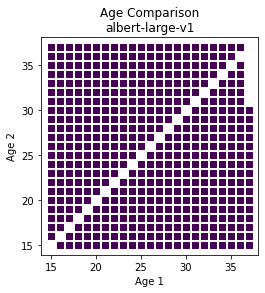

In [24]:
plt.scatter(first_age, second_age, c=all_preds, marker="s")
plt.title(f"Age Comparison\n{args.model_name_or_path}")
plt.axis("square")
plt.xlabel("Age 1")
plt.ylabel("Age 2")
#plt.savefig(f"imgs/{args.model_name_or_path.rsplit('/', 1)[-1]}-ages-double.jpg", bbox_inches="tight")
plt.show()

In [15]:
tokenizer.encode("<s>", add_special_tokens=False)

[0]

In [22]:
asdf = torch.tensor([[[1, 2], [3, 4], [5, 6]], [[11, 12], [13, 14], [15, 16]], [[21, 22], [23, 24], [25, 26]], [[31, 32], [33, 34], [35, 36]]])
asdf

tensor([[[ 1,  2],
         [ 3,  4],
         [ 5,  6]],

        [[11, 12],
         [13, 14],
         [15, 16]],

        [[21, 22],
         [23, 24],
         [25, 26]],

        [[31, 32],
         [33, 34],
         [35, 36]]])

In [26]:
inds = torch.tensor([[[0], [1], [0]], [[0], [0], [0]], [[0], [0], [0]], [[0], [0], [0]]])
torch.gather(asdf, 2, inds)

tensor([[[ 1],
         [ 4],
         [ 5]],

        [[11],
         [13],
         [15]],

        [[21],
         [23],
         [25]],

        [[31],
         [33],
         [35]]])